In [10]:
from google.colab import files
uploaded = files.upload()


Saving lab_petct_vox_5.00mm.h5 to lab_petct_vox_5.00mm.h5


In [19]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom


In [13]:
class PETCTDataset(Dataset):
    def __init__(self, h5_path, patient_ids, target_shape=(128, 128, 128)):
        self.file = h5py.File(h5_path, 'r')
        self.ids = patient_ids
        self.shape = target_shape

    def __len__(self):
        return len(self.ids)

    def normalize(self, arr):
        arr = np.clip(arr, np.percentile(arr, 1), np.percentile(arr, 99))
        return (arr - arr.min()) / (arr.max() - arr.min() + 1e-5)

    def resize_volume(self, vol):
        zoom_factors = [t / s for t, s in zip(self.shape, vol.shape)]
        return zoom(vol, zoom_factors, order=1)

    def __getitem__(self, idx):
        pid = self.ids[idx]
        ct = self.file[f'ct_data/{pid}'][:]
        pet = self.file[f'pet_data/{pid}'][:]
        label = self.file[f'label_data/{pid}'][:]

        ct = self.resize_volume(ct)
        pet = self.resize_volume(pet)
        label = self.resize_volume(label)

        ct = self.normalize(ct)
        pet = self.normalize(pet)
        label = (label > 0).astype(np.float32)

        input_vol = np.stack([pet, ct], axis=0)  # Shape: [2, D, H, W]
        return torch.tensor(input_vol, dtype=torch.float32), torch.tensor(label[None], dtype=torch.float32)


In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(2, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out = nn.Conv3d(32, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)


In [15]:
def dice_loss(pred, target, epsilon=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cuda


In [16]:
h5_path = '/content/lab_petct_vox_5.00mm.h5'
train_ids = ['STS_002', 'STS_003', 'STS_005', 'STS_012']

train_dataset = PETCTDataset(h5_path, train_ids)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for epoch in range(5):  # Start small
    model.train()
    epoch_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = dice_loss(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.4f}")
    print(f">>> Epoch {epoch+1} Avg Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1, Batch 1, Loss: 0.9992
Epoch 1, Batch 2, Loss: 0.9977
Epoch 1, Batch 3, Loss: 0.9984
Epoch 1, Batch 4, Loss: 0.9844
>>> Epoch 1 Avg Loss: 0.9949
Epoch 2, Batch 1, Loss: 0.9960
Epoch 2, Batch 2, Loss: 0.9982
Epoch 2, Batch 3, Loss: 0.9969
Epoch 2, Batch 4, Loss: 0.9822
>>> Epoch 2 Avg Loss: 0.9933
Epoch 3, Batch 1, Loss: 0.9967
Epoch 3, Batch 2, Loss: 0.9815
Epoch 3, Batch 3, Loss: 0.9980
Epoch 3, Batch 4, Loss: 0.9953
>>> Epoch 3 Avg Loss: 0.9929
Epoch 4, Batch 1, Loss: 0.9951
Epoch 4, Batch 2, Loss: 0.9964
Epoch 4, Batch 3, Loss: 0.9802
Epoch 4, Batch 4, Loss: 0.9979
>>> Epoch 4 Avg Loss: 0.9924
Epoch 5, Batch 1, Loss: 0.9793
Epoch 5, Batch 2, Loss: 0.9945
Epoch 5, Batch 3, Loss: 0.9962
Epoch 5, Batch 4, Loss: 0.9977
>>> Epoch 5 Avg Loss: 0.9919


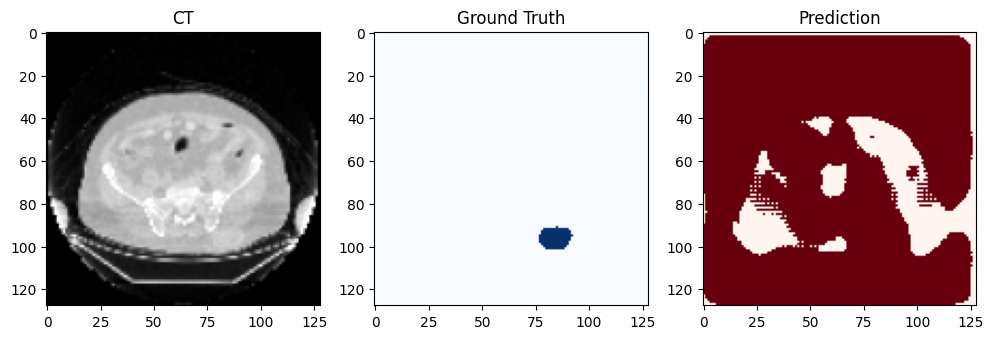

In [17]:
model.eval()
with torch.no_grad():
    x, y = train_dataset[0]
    x = x.unsqueeze(0).to(device)
    pred = torch.sigmoid(model(x)).squeeze().cpu().numpy()
    ct = x[0, 1].cpu().numpy()
    mask = y.squeeze().cpu().numpy()

    # Best slice with largest tumor area
    slice_index = mask.sum(axis=(1, 2)).argmax()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(ct[slice_index], cmap='gray')
    plt.title("CT")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[slice_index], cmap='Blues')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred[slice_index] > 0.5, cmap='Reds')
    plt.title("Prediction")

    plt.show()
